In [1]:
# %% load libs:
from collections import defaultdict
from os import path as op
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.lib.npyio import load

import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from scipy import stats

import mne
from mne import EvokedArray
# from mne.epochs import concatenate_epochs
from mne.decoding import (SlidingEstimator,  # GeneralizingEstimator,
                          cross_val_multiscore, LinearModel, get_coef)
from mne.stats import permutation_cluster_1samp_test, f_mway_rm, f_threshold_mway_rm

from library import config, helpers

In [2]:
# %% Functions:

def plot_score_per_factor(factor, data, scoring='roc_auc', sign_clusters=[], p_lvl=0.05, 
                          ylims=None, plt_dict=None, ax=None, n_boot=1000):

    print(config.colors['All'])
    sns.lineplot(x='time', 
                 y='score', 
                 hue=factor, 
                 data=data, 
                 n_boot=n_boot, 
                 palette=config.colors, 
                 ax=ax)
    ytick_range = ax.get_ylim()
    if ylims is None:
        ylims = ytick_range
    ax.set(xlim=(plt_dict['xmin'], plt_dict['xmax']), ylim=ylims)
    if scoring == 'roc_auc':
        scoring_str = 'ROC AUC'
    else: 
        scoring_str = scoring
    ax.set_ylabel(scoring_str)
    ax.set_xlabel('Time (s)')
    ax.axvspan(plt_dict['t_stimon'], plt_dict['t_stimon']+0.2, color='grey', alpha=0.3)
    ax.axvspan(plt_dict['t_stimon']+ 2.2, plt_dict['t_stimon'] + 2.5, color='grey', alpha=0.3)
    ax.vlines((plt_dict['t_stimon'], plt_dict['t_stimon']+0.2, plt_dict['t_stimon']+2.2),
              ymin=ylims[0], ymax=ylims[1], 
              linestyles='dashed')
    ax.hlines(0.5, xmin=plt_dict['xmin'], xmax=plt_dict['xmax'])
    p_lvl_str = 'p < .' + str(p_lvl).split('.')[-1]
    if isinstance(sign_clusters, dict):
        for i, key in enumerate(sign_clusters):
            col = config.colors[key]
            for sc in sign_clusters[key]:
                xmin = sc[0]
                xmax = sc[-1]
                ax.hlines(ylims[0] + (0.05 - ((i+1)*0.025)*np.ptp(ylims)), xmin=xmin, xmax=xmax, color=col, 
                          label=p_lvl_str)

    else:
        for sc in sign_clusters:
            xmin = sc[0]
            xmax = sc[-1]
            ax.hlines(ytick_range[0] + 0.05*np.ptp(ytick_range), xmin=xmin, xmax=xmax, color='purple', 
                    label=p_lvl_str)
    handles, labels = ax.get_legend_handles_labels()
    n_sgn_clu = None if len(sign_clusters) <= 1 else -(len(sign_clusters))
    #ax.legend(handles=handles[1:n_sgn_clu+1], labels=labels[1:n_sgn_clu+1])

def load_decod_res_all(epo_part='stimon', signaltype='collapsed', scoring='roc_auc', picks_str=None):
    data_dict = dict()
    
    if picks_str is not None:
        picks_str_folder = picks_str
    else:
        picks_str_folder = ''
    
    if len(ecc_list) == 0:
        ecc_list = ['']
    for ecc in ecc_list:
        data_dict[ecc] = {}
        contrast_str = f'LoadLow{ecc}_vs_LoadHigh{ecc}'
        fpath = op.join(config.paths['06_decoding-sensorspace'],
                                     epo_part,
                                     signaltype,
                                     contrast_str,
                                     scoring,
                                     picks_str_folder,
                                     'scores')
        fname = op.join(fpath, 'scores_per_sub.npy')
        data_dict[ecc]['scores'] = np.load(fname)
        data_dict[ecc]['times'] = np.load(fname[:-4] + '__times' + '.npy')
        fpath = op.join(config.paths['06_decoding-sensorspace'],
                        epo_part,
                        signaltype,
                        contrast_str,
                        scoring,
                        picks_str_folder,
                        'patterns')
        fname = op.join(fpath, 'patterns_per_sub.npy')
        data_dict[ecc]['patterns'] = np.load(fname)
    return(data_dict)
    


def load_decod_res_per_ecc(sub_list_str, ecc_list = [], epo_part='stimon', signaltype='collapsed', scoring='roc_auc', 
                           picks_str=None, gen_str=None):
    data_dict = dict()
    if picks_str is not None:
        picks_str_folder = picks_str
    else:
        picks_str_folder = ''
    
    if gen_str is not None:
        gen_folder = gen_str
    else:
        gen_folder = ''
    
    if len(ecc_list) == 0:
        ecc_list = ['']
    for ecc in ecc_list:
        data_dict[ecc] = dict(scores=[], times=[], patterns=[])
        contrast_str = f'LoadLow{ecc}_vs_LoadHigh{ecc}'
        for subID in sub_list_str:
            fpath = op.join(config.paths['06_decoding-sensorspace'],
                                         epo_part,
                                         signaltype,
                                         contrast_str,
                                         gen_folder,
                                         scoring,
                                         picks_str_folder,
                                         'scores')
            fname = op.join(fpath, f'{subID}-scores_per_sub.npy')
            scores_ = np.load(fname)
            data_dict[ecc]['scores'].append(scores_)            
            
            if len(data_dict[ecc]['times']) == 0:
                data_dict[ecc]['times'] = np.load(fname[:-4] + '__times' + '.npy')
            else:
                assert np.all(data_dict[ecc]['times'] == np.load(fname[:-4] + '__times' + '.npy'))
                
                
            fpath = op.join(config.paths['06_decoding-sensorspace'],
                                         epo_part,
                                         signaltype,
                                         contrast_str,
                                         gen_folder,
                                         scoring,
                                         picks_str_folder,
                                         'patterns')
            fname = op.join(fpath, f'{subID}-patterns_per_sub.npy')
            patterns_ = np.load(fname)
            data_dict[ecc]['patterns'].append(patterns_)
            
        data_dict[ecc]['scores'] = np.array(data_dict[ecc]['scores'])
        data_dict[ecc]['patterns'] = np.array(data_dict[ecc]['patterns'])
            
    return(data_dict)
 
def load_decod_res_chance_per_ecc(sub_list_str, ecc_list = [], epo_part='stimon', signaltype='collapsed', scoring='roc_auc', picks_str=None):
    data_dict = dict()
    if picks_str is not None:
        picks_str_folder = picks_str
    else:
        picks_str_folder = ''
        
    if len(ecc_list) == 0:
        ecc_list = ['']
    for ecc in ecc_list:
        data_dict[ecc] = dict(scores_chance=[], times_chance=[], patterns_chance=[])
        contrast_str = f'LoadLow{ecc}_vs_LoadHigh{ecc}'
        for subID in sub_list_str:
            fpath = op.join(config.paths['06_decoding-sensorspace'],
                                         epo_part,
                                         signaltype,
                                         contrast_str,
                                         scoring,
                                         picks_str_folder,
                                         'labels_shuffled',
                                         'scores')
            fname = op.join(fpath, f'{subID}-scores_per_sub.npy')
            scores_ = np.load(fname)
            data_dict[ecc]['scores_chance'].append(scores_)
            
            data_dict[ecc]['times_chance'] = np.load(fname[:-4] + '__times' + '.npy')
            if len(data_dict[ecc]['times_chance']) == 0:
                data_dict[ecc]['times_chance'] = np.load(fname[:-4] + '__times' + '.npy')
            else:
                assert np.all(data_dict[ecc]['times_chance'] == np.load(fname[:-4] + '__times' + '.npy'))
            
            fpath = op.join(config.paths['06_decoding-sensorspace'],
                                         epo_part,
                                         signaltype,
                                         contrast_str,
                                         scoring,
                                         picks_str_folder,
                                         'labels_shuffled',
                                         'patterns')
            fname = op.join(fpath, f'{subID}-patterns_per_sub.npy')
            patterns_ = np.load(fname)
            data_dict[ecc]['patterns_chance'].append(patterns_)
            
        data_dict[ecc]['scores_chance'] = np.array(data_dict[ecc]['scores_chance'])
        data_dict[ecc]['patterns_chance'] = np.array(data_dict[ecc]['patterns_chance'])
        
    return(data_dict)
 

    
    
def run_cbp_test(data):
    # number of permutations to run
    n_permutations = 10000 
    # set initial threshold
    p_initial = 0.05
    # set family-wise p-value
    p_thresh = 0.05
    connectivity = None
    tail = 1.  # 1 or -1 for one-sided test, 0 for two-sided

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = mne.stats.permutation_cluster_1samp_test(
        data, threshold=threshold, n_jobs=config.n_jobs, verbose=False, tail=tail,
        step_down_p=0.0005, adjacency=connectivity,
        n_permutations=n_permutations, seed=42, out_type='mask')

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return(T_obs, clusters, cluster_p_values)


def load_patterns(sub_list_str,
                  contrast_str,
                  epo_part='stimon',
                  signaltype='collapsed',
                  scoring='roc_auc',
                  reg='',
                  picks_str=None,
                  labels_shuffled=False):
    """Load the patterns from sensor space decoding.
    
    Parameters
    ----------
    sub_list_str : list, str
        List of subject IDs to load patterns from. 
    epo_part : str
        Which part the epo was cropped to; defaults to "stimon"
    contrast_str : str
        Decoded contrast.
    signaltype : str
        "collapsed" or "difference" or "uncollapsed" (not yet implemented). Defaults to "collapsed";
    scoring: str
        Scoring metric used during decoding. "roc_auc" (default), accuracy", or "balanced_accuracy";
    reg: str, float
        Regularization method used; Ints are interpreted as fixed shrinkage values; defaults to an empty string
    labels_shuffled : bool
        Allows to load the data from the run with shuffled labels.
    picks_str: str
        Predefined selection, has to be either 'Left', 'Right', 'Midline' or 'All'; None (default) is thesame as 'All'


    Returns
    -------
    patterns: ndarray
        Array with the patterns (subs x csp_components x channels x freqs x times)
    times: array, 1d
    freqs: array, 1d
    
    """

    if isinstance(reg, float):
        reg_str = 'shrinkage'+str(reg)
    else:
        reg_str = reg
    shuf_labs = 'labels_shuffled' if labels_shuffled else ''

    patterns_list = []
    times = []

    if (picks_str != None) and (picks_str != 'All'):
        picks_str_folder = picks_str
    else:
        picks_str_folder = 'All'
        
    for subID in sub_list_str:
        fpath = op.join(config.paths['06_decoding-sensorspace'],
                                     epo_part,
                                     signaltype,
                                     contrast_str,
                                     scoring,
                                     picks_str_folder,
                                     'patterns')
        fname = op.join(fpath, f'{subID}-patterns_per_sub.npy')
        patterns_ = np.load(fname)
        patterns_list.append(patterns_)
        if len(times) == 0:
            times = np.load(fname[:-4] + '__times' + '.npy')
        else:
            assert np.all(times == np.load(fname[:-4] + '__times' + '.npy')), "Times are different between subjects."
    

    patterns = np.concatenate(patterns_list)
    return patterns, times


def get_evoked_info(epo_part='stimon', signaltype='collapsed', picks_str=None):
    fname = op.join(config.paths['03_preproc-pooled'],
                    epo_part,
                    signaltype,
                    f'VME_S01-{epo_part}-{signaltype}-epo.fif')
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)
    
    # pick channel selection:
    if (picks_str != None) and (picks_str != 'All'):
        roi_dict = mne.channels.make_1020_channel_selections(epos.info)
        picks = [epos.ch_names[idx] for idx in roi_dict[picks_str]]
        epos.pick_channels(picks, ordered=True)


    return(epos.info)

def l2norm(vec):
    out = np.sqrt(np.sum(vec**2))
    return out
  

In [3]:
# Setup:

# plotting:
plt_dict = defaultdict(dict)
pp = {'t_stimon':  0,
      'xmin': -0.2,
      'xmax': 2.3}
plt_dict['stimon'] = pp

p_val_cbp = 0.05

# structuring data:
sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

event_dict = config.event_dict
cond_dict = {'Load': ['LoadLow', 'LoadHigh'],
             'Ecc': ['EccS', 'EccM', 'EccL']}

### Plot decoding accuracy averaged across eccentricities

In [4]:
data_dict_all = load_decod_res_per_ecc(sub_list_str=sub_list_str, picks_str='All')
data_dict_all['All'] = data_dict_all.pop('')
data_dict_chance = load_decod_res_chance_per_ecc(sub_list_str=sub_list_str, picks_str='All')  

In [5]:
config.colors['All'] = 'blue'

In [6]:
data_dict_all['All'].keys()

dict_keys(['scores', 'times', 'patterns'])

In [7]:
# %%

# Prepare data for plotting with seaborn:
results_df_list = list()
times = data_dict_all['All']['times']
acc = np.asarray(data_dict_all['All']['scores'])
acc_df = pd.DataFrame(acc)
acc_df.columns = times
df = acc_df.melt(var_name='time', value_name='score')  # put into long format
df['Ecc'] = 'All'
data_plot = df

# # add chance level data:
acc_chance = np.asarray(data_dict_chance['']['scores_chance'])
acc_df_chance = pd.DataFrame(acc_chance)
acc_df_chance.columns = times
df_chance = acc_df_chance.melt(var_name='time', value_name='score')  # put into long format
df_chance['Ecc'] = 'Chance'
data_plot = pd.concat([data_plot, df_chance])

# # run CBP to find differences from chance:
sign_cluster_times = dict()

data = np.asarray(data_dict_all['All']['scores']) - np.asarray(data_dict_chance['']['scores_chance'])
t_values, clusters, p_values = run_cbp_test(data)
idx_sign_clusters = np.argwhere(p_values<p_val_cbp)
sign_cluster_times = [times[clusters[idx[0]]][[0,-1]] for idx in idx_sign_clusters]

In [8]:
data_plot2 = data_plot.copy()
data_plot2.reset_index().index

RangeIndex(start=0, stop=6132, step=1)

blue


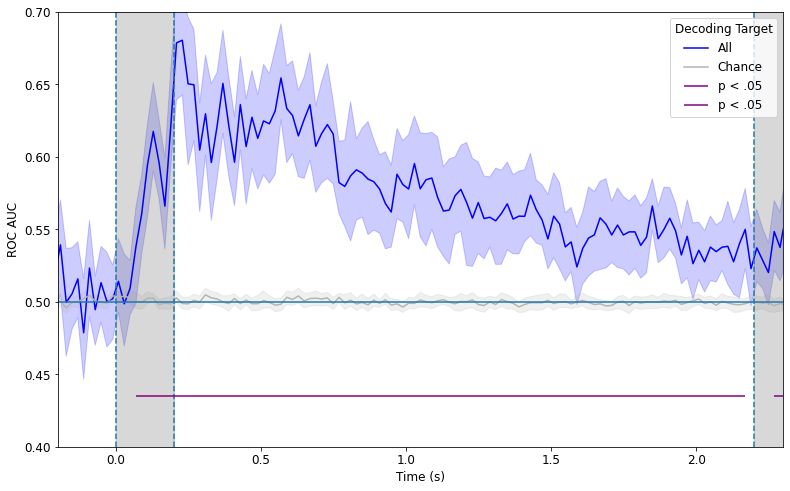

In [9]:
plt.rcParams['font.size'] = 12
plt.rcParams["legend.fontsize"] = 12

# Plot it:
fig, ax = plt.subplots(1, figsize=(13,8))
plot_score_per_factor(factor='Ecc',
                      data=data_plot.reset_index(),
                      plt_dict=plt_dict['stimon'], 
                      scoring='roc_auc',
                      sign_clusters=sign_cluster_times,
                      p_lvl=p_val_cbp,
                      ylims=[0.4, 0.7],
                      n_boot=100, ax=ax)
#ax.legend(title='Decoding Target', labels=['Load: 2 vs. 4', 'chance', 'p < .01'], loc=1)

handles, labels = ax.get_legend_handles_labels()
n_sgn_clu = None if len(sign_cluster_times) <= 1 else -(len(sign_cluster_times)+1)
ax.legend(handles=handles[1:n_sgn_clu], title='Decoding Target', labels=['Load: 2 vs. 4', 'chance', '$\it{p}$ < ' + "{0:.2f}".format(p_val_cbp)[1:]], loc=1)

fpath = op.join(config.paths['plots'], '09_temporal_decoding')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'AUC-Load_overall.svg')
plt.savefig(fname)

Extract the values for the highest decoding accuracy

In [10]:
decod_scores = data_plot[data_plot.Ecc == 'All'].groupby('time').agg(
                acc_mean=("score", np.mean),
                acc_sd=("score", np.std)
).reset_index()

decod_max = decod_scores[decod_scores.acc_mean == np.max(decod_scores.acc_mean)]

helpers.extract_var("decod_sensorspace_all_peak_mean", decod_max.acc_mean.iloc[0], exp_format='.2f')
helpers.extract_var("decod_sensorspace_all_peak_sd", decod_max.acc_sd.iloc[0], exp_format='.2f')
helpers.extract_var("decod_sensorspace_all_peak_t", decod_max.time.iloc[0], exp_format='.3f')

In [11]:
helpers.extract_var("decod_sensorspace_sign_cluster_t_start", sign_cluster_times[0][0] * 1000, 
                    exp_format=".3f")
helpers.extract_var("decod_sensorspace_sign_cluster_t_end", sign_cluster_times[0][1] * 1000,
                    exp_format=".3f")

In [12]:
# %%
eccs = cond_dict['Ecc']

data_dict = load_decod_res_per_ecc(sub_list_str, eccs, picks_str='All')
data_dict_chance = load_decod_res_chance_per_ecc(sub_list_str, eccs, picks_str='All')  # for simplicity we only use the data from one condition

In [13]:
data_dict_chance.keys()

dict_keys(['EccS', 'EccM', 'EccL'])

In [14]:
# Prepare data for plotting with seaborn:
results_df_list = list()
for ecc in eccs:
    times = data_dict[ecc]['times']
    acc = np.asarray(data_dict[ecc]['scores'])
    acc_df = pd.DataFrame(acc)
    acc_df.columns = times
    df = acc_df.melt(var_name='time', value_name='score')  # put into long format
    df['Ecc'] = ecc
    results_df_list.append(df)
data_plot = pd.concat(results_df_list)

# add chance level data:
acc_chance = np.asarray(data_dict_chance['EccM']['scores_chance'])
acc_df_chance = pd.DataFrame(acc_chance)
acc_df_chance.columns = times
df_chance = acc_df_chance.melt(var_name='time', value_name='score')  # put into long format
df_chance['Ecc'] = 'Chance'
data_plot = pd.concat([data_plot, df_chance])

# run CBP to find differences from chance:
sign_cluster_times = dict()
for ecc in cond_dict['Ecc']:
    data = np.asarray(data_dict[ecc]['scores']) - np.asarray(data_dict_chance[ecc]['scores_chance'])
    t_values, clusters, p_values = run_cbp_test(data)
    idx_sign_clusters = np.argwhere(p_values<p_val_cbp)
    sign_cluster_times[ecc] = [times[clusters[idx[0]]][[0,-1]] for idx in idx_sign_clusters]
    

### run CBP to find differences between conditions:
Code massively inspired/taken from:  
https://mne.tools/stable/auto_tutorials/stats-source-space/plot_stats_cluster_time_frequency_repeated_measures_anova.html#sphx-glr-auto-tutorials-stats-source-space-plot-stats-cluster-time-frequency-repeated-measures-anova-py


In [15]:
factor_levels = [3]
effects = ['A']

def stat_fun(*data_):
    return f_mway_rm(np.swapaxes(data_, 1, 0), factor_levels=factor_levels,
                         effects=effects, return_pvals=False)[0]

# get data:
scores_list = list()
for i, ecc in enumerate(cond_dict['Ecc']):
    scores_tmp = data_dict[ecc]['scores']
    scores_list.append(scores_tmp)
data = np.asarray(scores_list)

# The ANOVA returns a tuple f-values and p-values, we will pick the former.
pthresh = p_val_cbp
f_thresh = f_threshold_mway_rm(len(data[0]), factor_levels, effects,
                               pthresh)
tail = 1  # f-test, so tail > 0
n_permutations = 10000  # Save some time (the test won't be too sensitive ...)
T_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(data, 
                                                                            stat_fun=stat_fun, 
                                                                            threshold=f_thresh, 
                                                                            tail=tail, 
                                                                            n_jobs=-2,
                                                                            n_permutations=n_permutations, 
                                                                            buffer_size=None, 
                                                                            out_type='mask', 
                                                                            seed=42)

# add sign times to the plotting data dict
idx_sign_diff_clusters = np.argwhere(cluster_p_values<p_val_cbp)
sign_cluster_times['Diff'] = [times[clusters[idx[0]]][[0,-1]] for idx in idx_sign_diff_clusters]

stat_fun(H1): min=0.003058 max=5.319275
Running initial clustering
Found 5 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [20]:
cluster_p_values

array([0.7899, 0.3363, 0.9789, 0.9545, 0.9768])

blue


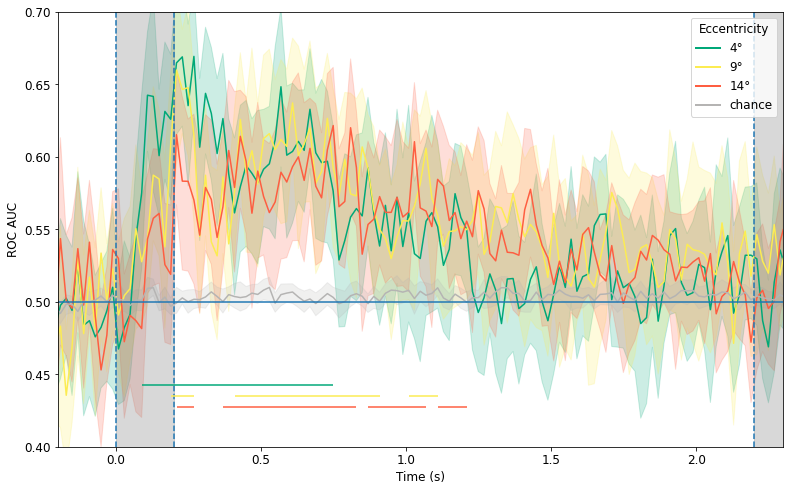

In [23]:
# %%

plt.rcParams['font.size'] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams['svg.fonttype'] = 'none'

# Plot it:
fig, ax = plt.subplots(1, figsize=(13,8))
plot_score_per_factor('Ecc', data=data_plot.reset_index(), plt_dict=plt_dict['stimon'], 
                      scoring='roc_auc', sign_clusters=sign_cluster_times, p_lvl=p_val_cbp, ylims=[0.4, 0.7],
                      n_boot=100, ax=ax)
custom_lines = [matplotlib.lines.Line2D([0], [0], color=config.colors['EccS'], lw=2),
                matplotlib.lines.Line2D([0], [0], color=config.colors['EccM'], lw=2),
                matplotlib.lines.Line2D([0], [0], color=config.colors['EccL'], lw=2),
                matplotlib.lines.Line2D([0], [0], color=config.colors['Chance'], lw=2)]
ax.legend(handles=custom_lines,title='Eccentricity', labels=['4°', '9°', '14°', 'chance'], loc=1)


fpath = op.join(config.paths['plots'], '09_temporal_decoding')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'AUC-Load_per_Ecc.svg')
plt.savefig(fname)

# Plot the patterns of the decoder

We first normalize each pattern vector per subject and timepoint:

In [264]:
%matplotlib qt

picks= 'All'

ecc_cond = '' # 'EccL' # <<<< '' (aka empty string): all eccentricities

sub_patterns, times = load_patterns(sub_list_str, f'LoadLow{ecc_cond}_vs_LoadHigh{ecc_cond}', picks_str=picks)
sub_patterns_norm = np.zeros_like(sub_patterns)
# normalize them by L2 norm to allow for unbiased averages:
for sub in range(sub_patterns.shape[0]):
    for time in range(sub_patterns.shape[-1]):
        sub_patterns_norm[sub, :, time] = sub_patterns[sub, :, time] / l2norm(sub_patterns[sub,:,time])

Next, we average per timepoint across subjects and normalize once more per timepoint (so we can meaningfully use one color scale):

In [265]:
sub_patterns_avg = sub_patterns_norm.copy().mean(axis=0)
sub_patterns_avg_norm = np.stack([sub_patterns_avg[:,ii] / l2norm(sub_patterns_avg[:,ii]) for ii in range(sub_patterns_avg.shape[-1])], axis=-1)

In [266]:
# Build new pseudo Evoke obj:
sub_patterns_evo = EvokedArray(sub_patterns_avg_norm, dummy_epos_info)
sub_patterns_evo.times = times

times_plot = [0.2, 0.5, 0.75, 1.0, 1.25, 1.75]
plt_load = sub_patterns_evo.plot_topomap(times = times_plot, 
                                   scalings=1, 
                                   units='',
                                   title=f"{ecc_cond} -- Decod. Target: {config.labels['Load']}",
                                   cmap = 'RdBu_r',
                                   vmin = -0.4,
                                   vmax=0.4,
                                   contours=10,
                                   ch_type='eeg',
                                   extrapolate='local')

Save it:

In [267]:
fpath = op.join(config.paths['plots'], '05_temporal_decoding')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, f'LoadLow{ecc_cond}_vs_LoadHigh{ecc_cond}_patterns_avg.svg')
plt_load.savefig(fname)

Plot it for each subject separately:

In [ ]:
nsubs = len(sub_list_str)
times_plot = [0.2, 0.5, 0.75, 1.0, 1.25, 1.75]
fig, axes = plt.subplots(nsubs, len(times_plot), figsize=(15,60))
for i in range(nsubs):
    sub_patterns_ = sub_patterns_norm[i,:,:].squeeze()
    
    # get dummy epos.info file to get electrode locations
    dummy_epos_info = get_evoked_info(picks_str='All')

    # Build new pseudo Evoke obj:
    sub_patterns_evo = EvokedArray(sub_patterns_, dummy_epos_info)
    sub_patterns_evo.times = times

    if i==0:
        time_format=None
    else:
        time_format=""
    plt_load_all = sub_patterns_evo.plot_topomap(times = times_plot, 
                                       scalings=1, 
                                       units='',
                                       title=config.labels['Load'],
                                       cmap = 'RdBu_r',
                                       vmin = -0.4,
                                       vmax=0.4,
                                       contours=10,
                                       time_format=time_format,
                                       ch_type='eeg',
                                       colorbar=False,
                                       extrapolate='local',
                                       axes=axes[i][:])
    

Save it:

In [237]:
fpath = op.join(config.paths['plots'], '05_temporal_decoding')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'LoadLow_vs_LoadHigh_patterns_allsubjects.svg')
plt_load_all.savefig(fname)

### Plot results decoded from the separate hemispheres (not yet calculated)

In [28]:
config.colors['Ipsi'] = '#FAC748'
config.colors['Contra'] = '#8390FA'

In [29]:
eccs = ['']

data_dict = load_decod_res_per_ecc(eccs, picks_str='Left')
data_dict_ipsi = load_decod_res_per_ecc(eccs, picks_str='Right')  # for simplicity we only use the data from one condition

# %%

# Prepare left sensor data for plotting with seaborn:
results_df_list = list()
for ecc in eccs:
    times = data_dict[ecc]['times']
    acc = np.asarray(data_dict[ecc]['scores'])
    acc_df = pd.DataFrame(acc)
    acc_df.columns = times
    df = acc_df.melt(var_name='time', value_name='score')  # put into long format
    df['Ecc'] = 'Contra'
    results_df_list.append(df)
# data_plot = pd.concat(results_df_list)

# # add data from right sensors:

for ecc in eccs:
    times = data_dict_ipsi[ecc]['times']
    acc = np.asarray(data_dict_ipsi[ecc]['scores'])
    acc_df = pd.DataFrame(acc)
    acc_df.columns = times
    df = acc_df.melt(var_name='time', value_name='score')  # put into long format
    df['Ecc'] = 'Ipsi'
    results_df_list.append(df)



data_plot = pd.concat(results_df_list)

# run CBP to find differences from chance:
sign_cluster_times = dict()
for ecc in eccs:
    data = np.asarray(data_dict['']['scores']) - np.asarray(data_dict_ipsi['']['scores'])
    t_values, clusters, p_values = run_cbp_test(data)
    idx_sign_clusters = np.argwhere(p_values<0.05) #p_val_cbp)
    sign_cluster_times['Diff'] = [times[clusters[idx[0]]][[0,-1]] for idx in idx_sign_clusters]

FileNotFoundError: [Errno 2] No such file or directory: '/raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/06_decoding/sensorspace/stimon/collapsed/LoadLow_vs_LoadHigh/roc_auc/Left/scores/-scores_per_sub.npy'

['Ecc', 'Contra', 'Ipsi']


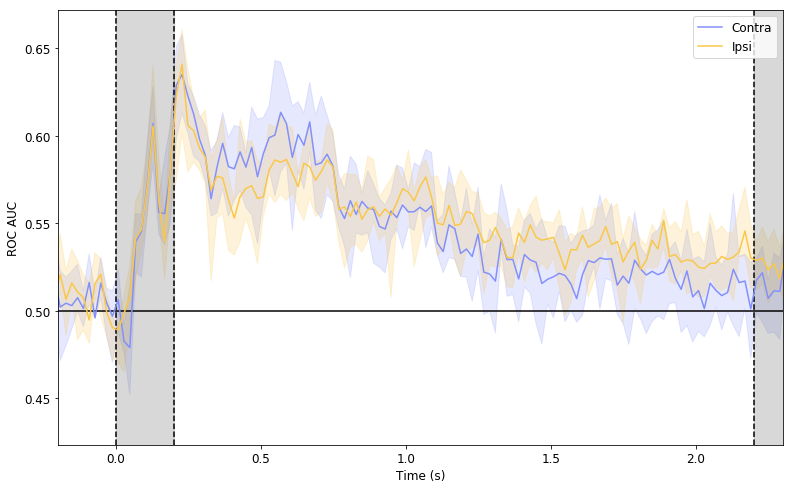

In [29]:

plt.rcParams['font.size'] = 12
plt.rcParams["legend.fontsize"] = 12

# Plot it:
fig, ax = plt.subplots(1, figsize=(13,8))
plot_score_per_factor('Ecc', data=data_plot, plt_dict=plt_dict['stimon'], 
                      scoring='roc_auc', sign_clusters=sign_cluster_times, p_lvl=p_val_cbp, n_boot=10, ax=ax)
ax.legend(title='', labels=['Contra', 'Ipsi'], loc=1)


fpath = op.join(config.path_plots, '09_temporal_decoding')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'AUC-Load_per_hemisphere.png')
#plt.savefig(fname)

### Plotting the results of the temporal generalizing analysis (not yet calculated)

In [39]:
data_dict_all = load_decod_res_per_ecc(picks_str='All', gen_str='gen_temp')
data_dict_all['All'] = data_dict_all.pop('')
data_dict_chance = load_decod_res_chance_per_ecc(picks_str='All') 

In [40]:
scores = data_dict_all['All']['scores']
times = data_dict_all['All']['times']

scores = np.mean(scores, axis=0)

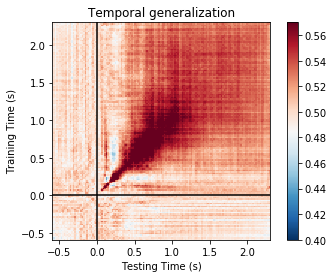

In [42]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation=None, # 'lanczos', 
               origin='lower', cmap='RdBu_r',
               extent=times[[0, -1, 0, -1]], vmin=0.4, vmax=0.57)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)